# Bike Sharing Assignment

### Problem Statement:

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues. They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

* Which variables are significant in predicting the demand for shared bikes. 
* How well those variables describe the bike demands


In [1]:
# Importing all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

 ### Step 1:  Data Exploration 


In [2]:
#Importing dataset 
bike = pd.read_csv("day.csv")

In [3]:
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
#Checking whether if there is any missing value.
bike.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

**Dropping the unnecessary variables: ‘instant’, ‘dteday’, ‘casual’ and ‘registered’**

In [5]:
bike = bike.drop(['instant','dteday','casual','registered'],axis = 1)

### Step 2: Data Vizualization 

#### 1. Count of total rental bikes across various seasons and weather

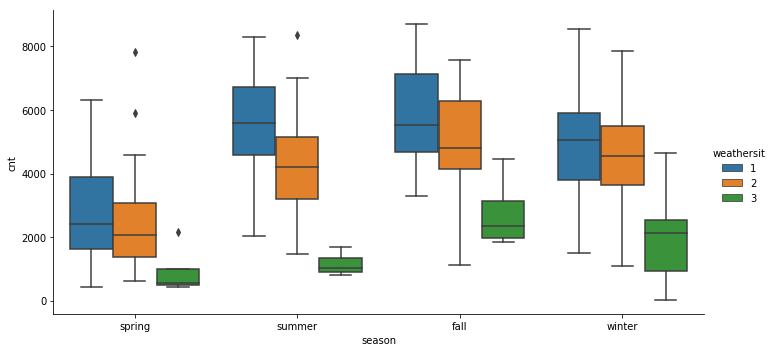

In [6]:
g=sns.catplot(x = 'season', y = 'cnt', hue = 'weathersit', data = bike , kind='box',height=5, aspect=2)
g.set(xticklabels=['spring', 'summer','fall','winter'])

#### 2. Count of total rental bikes across various days of week also on holiday vs no holiday 

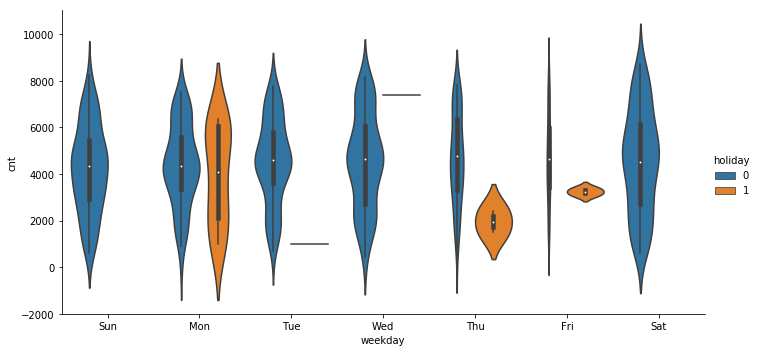

In [7]:
g=sns.catplot(x = 'weekday', y = 'cnt', hue = 'holiday', data = bike,kind='violin',height=5, aspect=2)
g.set(xticklabels=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])

#### 3. Count of total rental bikes across various months and year during  workingday  or non-workingday 

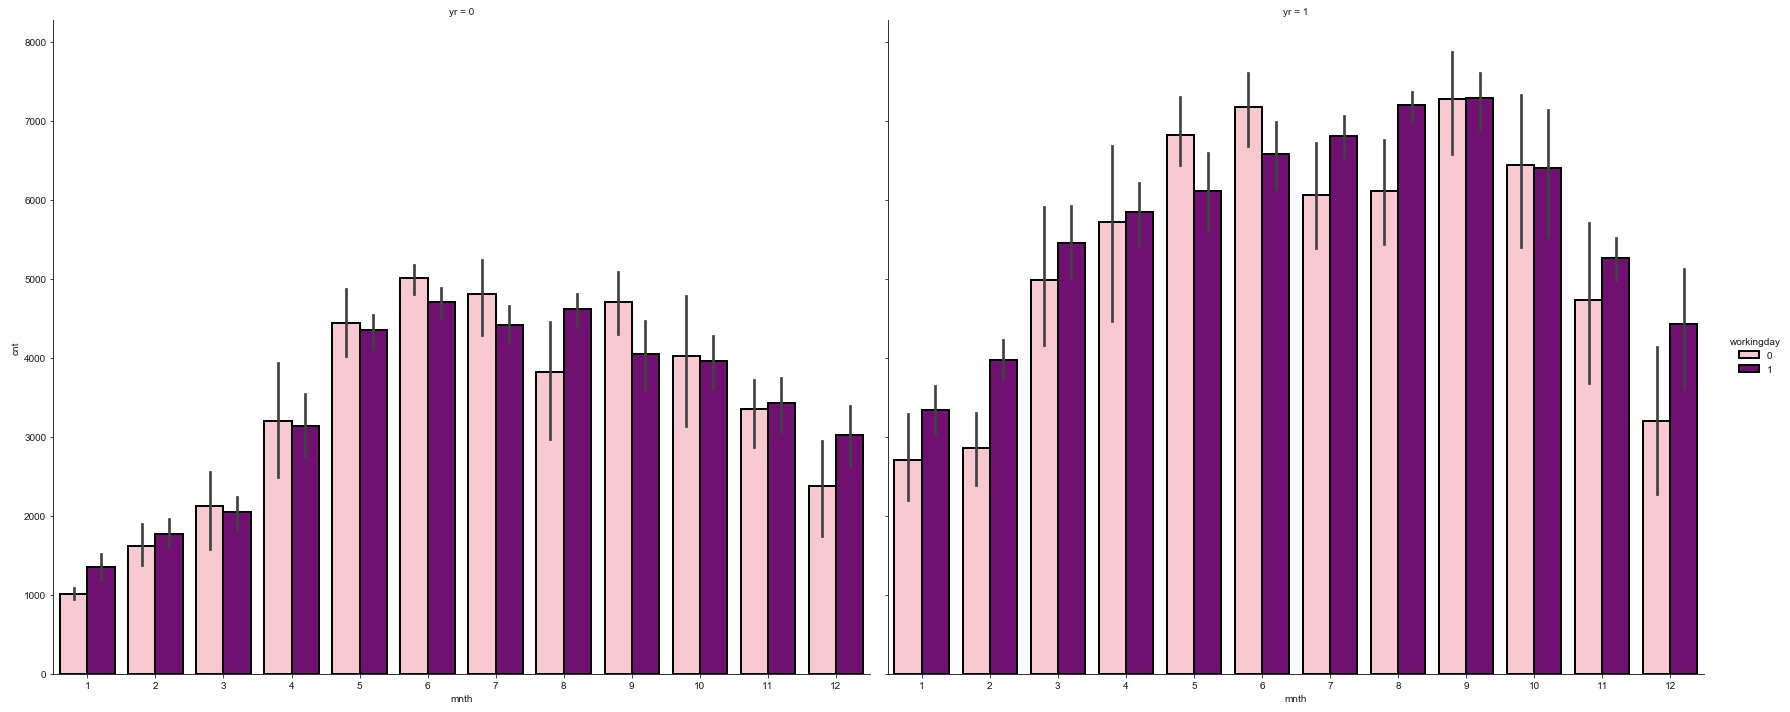

In [8]:
g=sns.catplot(x="mnth", y="cnt",
                hue="workingday", col="yr",
                data=bike, kind="bar",palette=['pink','purple'],edgecolor=(0,0,0),
                  linewidth=2, height=10, aspect=1.2)
sns.set(rc={"font.style":"normal",
            'axes.labelsize':20,
            'xtick.labelsize':20,
            'font.size':20,
            'ytick.labelsize':20})


#### 4. Various in count of total rental bikes over different temperature, humidity , windspeed during holiday vs non-holiday day

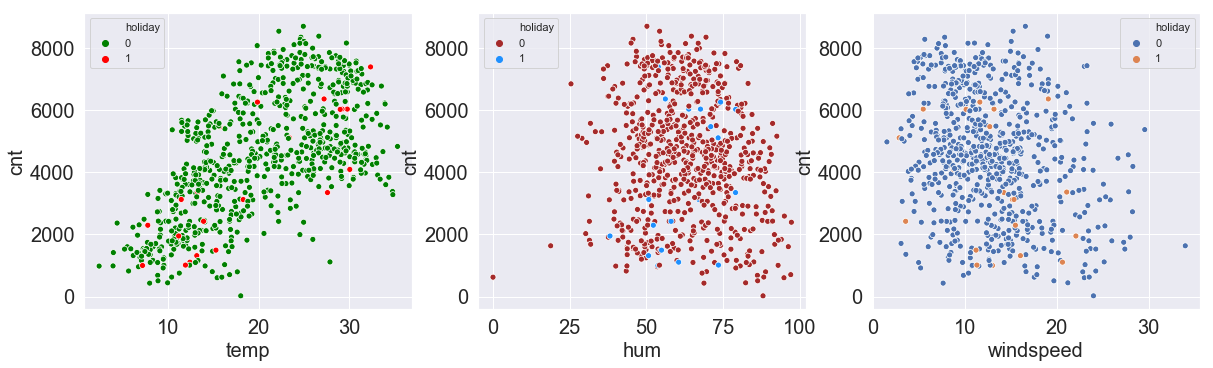

In [9]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.scatterplot(x = 'temp', y = 'cnt', hue='holiday' ,data = bike, palette=['green','red'])
plt.subplot(2,3,2)
sns.scatterplot(x = 'hum', y = 'cnt', hue='holiday',data = bike, palette=['brown','dodgerblue'])
plt.subplot(2,3,3)
sns.scatterplot(x = 'windspeed', y = 'cnt',hue='holiday', data = bike)


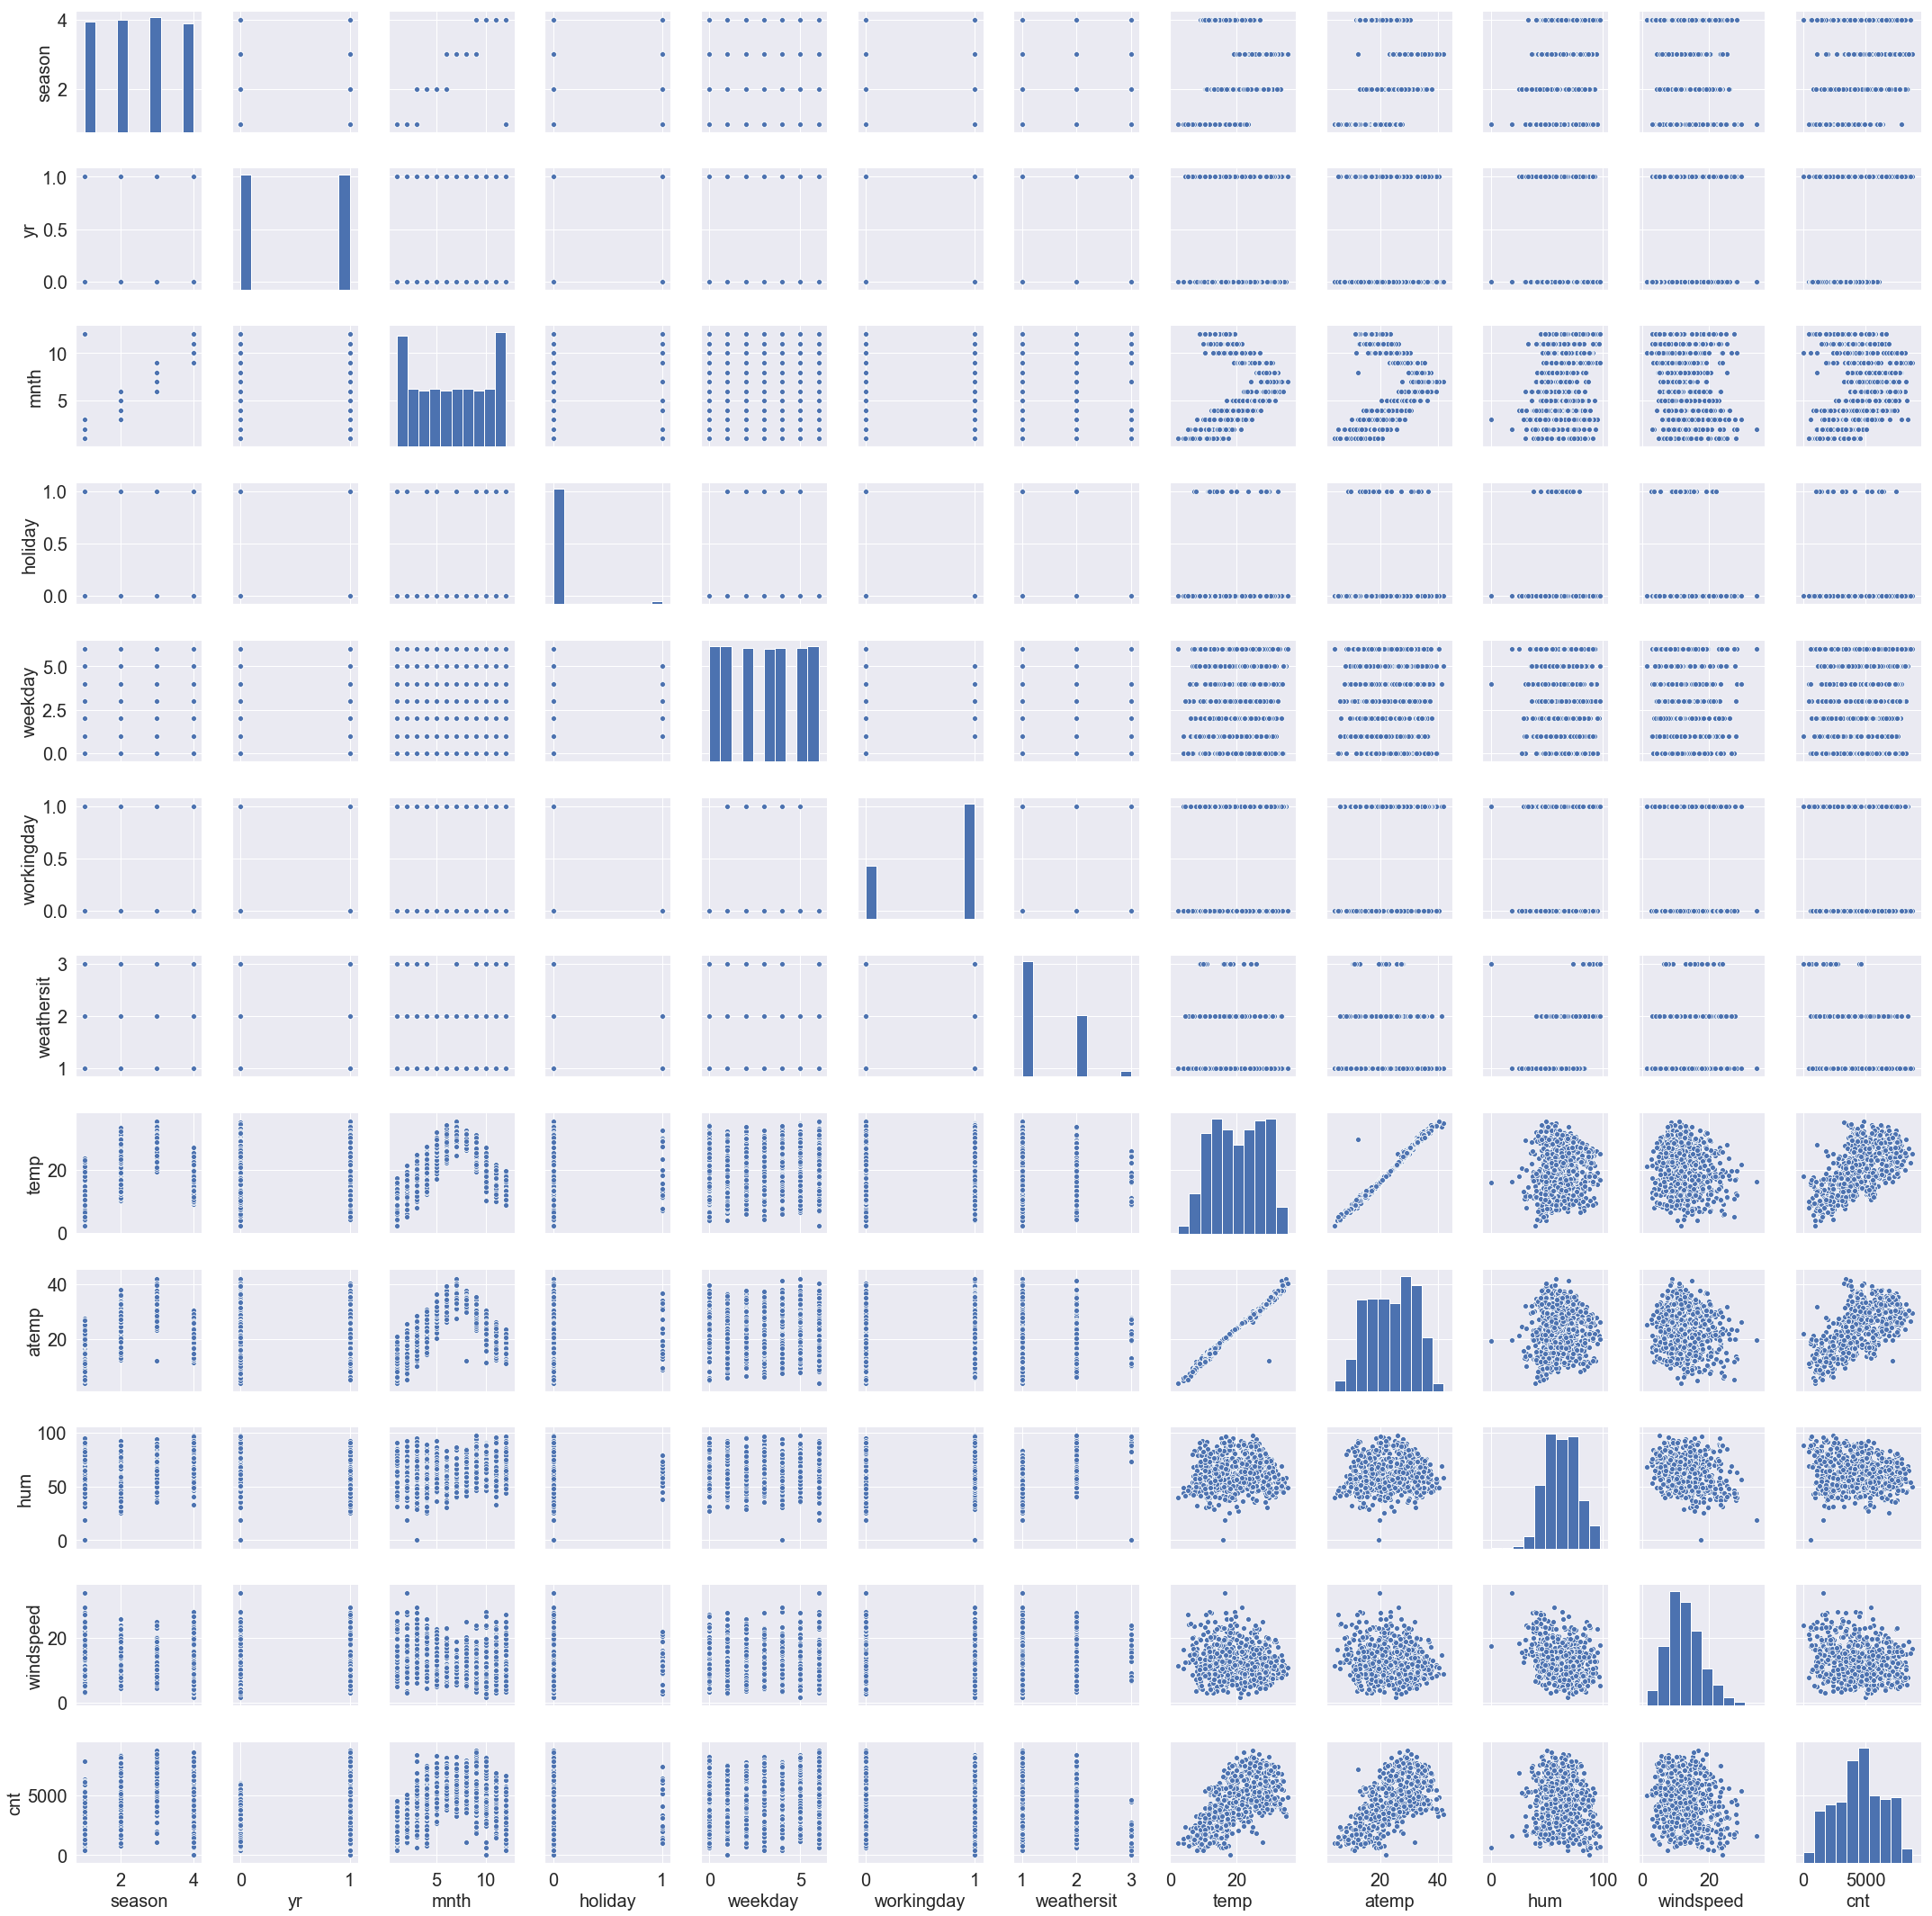

In [10]:
sns.pairplot(bike)
plt.show()

 #### Let's check the correlation coefficients to see which variables are highly correlated

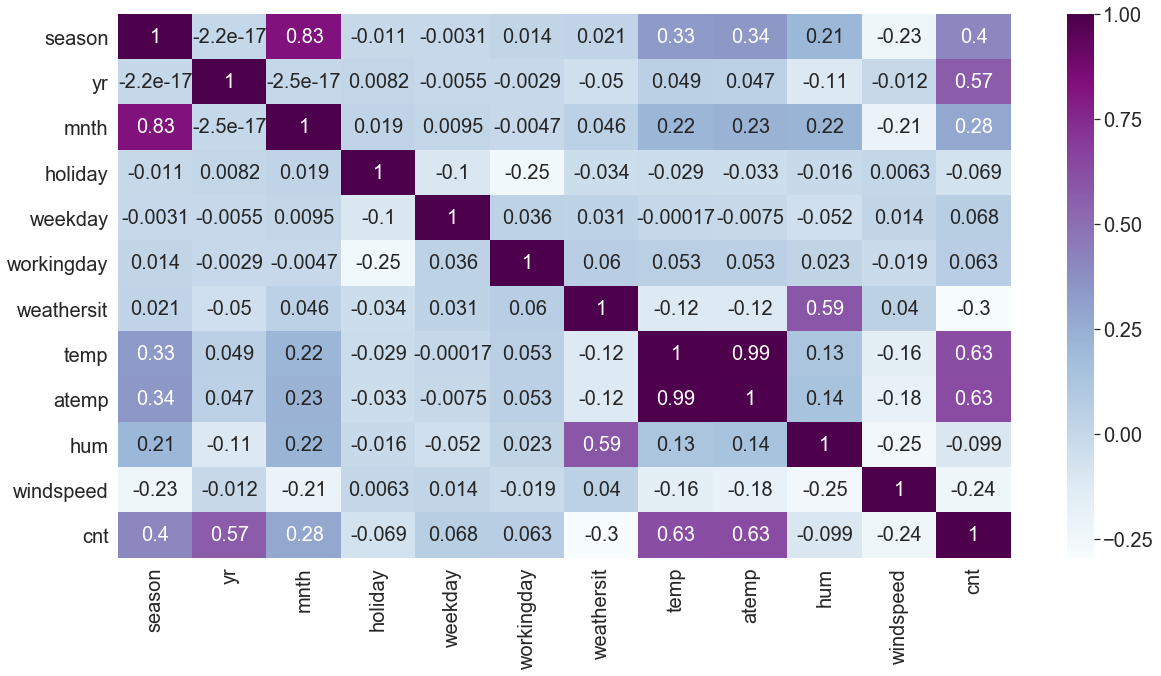

In [11]:
plt.figure(figsize = (20, 10))
sns.heatmap(bike.corr(), annot = True, cmap="BuPu")
plt.show()

In [12]:
#Storing the original data 
original_data=bike[['season','yr','mnth','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','cnt']]
original_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


### Step 3: Data Preparation

**Identify the categorical and continuous features**

* categorical features = season , yr, holiday, weekday, workingday, weathersit 
* continuous features = temp, atemp, hum, windspeed, cnt 

####  Dealing with categorical features 

 #### Identify the categorical and continuous features

As in order to proceed with processing of categorical variable, make sure their datatype is object

In [13]:
print(bike.columns)
bike.dtypes

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')


season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

Converting categorical variables into Object datatype

In [14]:
bike['season']= bike['season'].astype(object)
#bike['yr']= bike['yr'].astype(object)
bike['mnth']= bike['mnth'].astype(object)
#bike['holiday']= bike['holiday'].astype(object)
bike['weekday']= bike['weekday'].astype(object)
#bike['workingday']= bike['workingday'].astype(object)
bike['weathersit']= bike['weathersit'].astype(object)
bike.dtypes

season         object
yr              int64
mnth           object
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

Get the dummy variables for the Categorical features :
Since there are different numbers in the same column, the model will misunderstand the data to be in some kind of order, 0 < 1   <2.To overcome this problem, we use dummy variables

In [15]:

X=bike[['season', 'mnth', 'weekday','weathersit']]

# Let's drop the first column to remove redundancy
cat_vars = pd.get_dummies(X,drop_first=True )

# Drop the columns that as we have created the dummies for 
bike.drop(['season', 'mnth', 'weekday','weathersit'], axis = 1, inplace = True)


Add the results to the original dataframe

In [16]:
bike = pd.concat([cat_vars, bike], axis = 1)
bike.columns

Index(['season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3', 'yr',
       'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

### Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

In [17]:
# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(bike, train_size = 0.7, test_size = 0.3, random_state = 100)


#### Dealing with continuous features

Rescaling the Features :
  it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale.

In [18]:
#Min-Max scaling
scaler = MinMaxScaler()

# Apply scaler() to all the columns except the 'dummy' variables.
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [19]:
df_train.head()

,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,...,weathersit_2,weathersit_3,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
653,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243
576,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658
426,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255
728,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096
482,1,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973


In [20]:
df_train.describe()

,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,...,weathersit_2,weathersit_3,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.245098,0.262745,0.24902,0.066667,0.098039,0.078431,0.084314,0.074510,0.076471,0.096078,...,0.343137,0.029412,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620
std,0.430568,0.440557,0.43287,0.249689,0.297660,0.269113,0.278131,0.262857,0.266010,0.294988,...,0.475223,0.169124,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638
75%,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing into X and Y sets for the model building

In [21]:
y_train = df_train.pop('cnt')
X_train = df_train

## Step 5: Building our model


**Before starting the model , lets see whicg features are highly correleated with the target variable**

In [22]:
cor = original_data.corr()
#Correlation with output variable
cor_target = abs(cor['cnt'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>abs(0.2) ]
relevant_features.sort_values(ascending=False)

cnt           1.000000
atemp         0.630685
temp          0.627044
yr            0.569728
season        0.404584
weathersit    0.295929
mnth          0.278191
windspeed     0.235132
Name: cnt, dtype: float64

We can see ,  these are the features with high correlation coefficient with the target variable ie 'cnt' :
* temp      0.627494
* atemp     0.631066
* yr        0.566710
* season    0.406100

### MODEL I : Recursive feature elimination



In [23]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train, y_train)

In [24]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('mnth_2', False, 7),
 ('mnth_3', False, 2),
 ('mnth_4', False, 4),
 ('mnth_5', False, 3),
 ('mnth_6', False, 5),
 ('mnth_7', False, 8),
 ('mnth_8', True, 1),
 ('mnth_9', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 9),
 ('mnth_12', False, 10),
 ('weekday_1', False, 11),
 ('weekday_2', False, 12),
 ('weekday_3', False, 14),
 ('weekday_4', False, 15),
 ('weekday_5', False, 13),
 ('weekday_6', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1)]

In [25]:
# Columns supported by RFE
col = X_train.columns[rfe.support_]
col

Index(['season_2', 'season_3', 'season_4', 'mnth_8', 'mnth_9', 'mnth_10',
       'weekday_6', 'weathersit_2', 'weathersit_3', 'yr', 'holiday',
       'workingday', 'temp', 'hum', 'windspeed'],
      dtype='object')

In [26]:
# Columns not supported by RFE
X_train.columns[~rfe.support_]

Index(['mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_11',
       'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'atemp'],
      dtype='object')

In [27]:
# Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [28]:
#Renaming the columns for better understanding
X_train_rfe.rename(columns = {'season_2':'summer', 'season_3':'fall', 
                              'season_4':'winter','mnth_8':'August','mnth_9':'September','mnth_10':'October',
                            'weekday_6':'Saturday','weathersit_2':'Mist','weathersit_3':'Light_Snow'
                             }, inplace = True) 

#### Building the first model 

In [29]:
# Adding a constant variable  
X_train_rfe = sm.add_constant(X_train_rfe)

In [30]:
# Running the linear model
lm= sm.OLS(y_train,X_train_rfe).fit()   

In [31]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.7
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          1.89e-191
Time:                        15:16:40   Log-Likelihood:                 520.09
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1950      0.029      6.791      0.0

As, we can see p-values of all the variable seems to be significant (ie less than 0.05) except fall. fall is insignificant in presence of other variables. 

#### Checking VIF 

In [32]:

#Dropping constant to check the VIF values
X=X_train_rfe.drop(['const'],axis = 1)

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,temp,24.06
13,hum,17.47
1,fall,8.19
11,workingday,5.05
14,windspeed,3.88
0,summer,3.44
2,winter,2.88
7,Mist,2.15
9,yr,2.04
6,Saturday,1.90


We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.
As you can see from the summary and the VIF dataframe, some variables are still insignificant.
**But our priority will be high p-value variable first. So will be dropping "fall"**.

In [33]:
X_train_new = X_train_rfe.drop(['fall'],axis = 1)

#### Dropping the variable and updating the model without "fall"

In [34]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new = sm.add_constant(X_train_new)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     197.5
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          3.24e-192
Time:                        15:16:40   Log-Likelihood:                 519.16
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     495   BIC:                            -944.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1945      0.029      6.770      0.0

All the p-values of features seems to be significant . Now lets check Multicollinearity among different features.

#### Calculate the VIFs for the  new model 

In [35]:
#Dropping constant to check the VIF values
X=X_train_new.drop('const', 1)

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,hum,16.59
11,temp,10.01
10,workingday,5.05
13,windspeed,3.82
1,winter,2.27
6,Mist,2.14
8,yr,2.03
5,Saturday,1.90
0,summer,1.83
4,October,1.62


#### Dropping the Variable and Updating the Model
As you can notice ,now hum variable have high VIF.Hence, this variable isn't of much use and should be dropped.

In [36]:
X_train_new2 = X_train_new.drop(['hum'],axis = 1)

In [37]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new2 = sm.add_constant(X_train_new2)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new2).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     202.9
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          6.16e-189
Time:                        15:16:40   Log-Likelihood:                 508.57
No. Observations:                 510   AIC:                            -989.1
Df Residuals:                     496   BIC:                            -929.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0945      0.019      4.961      0.0

In [38]:
#Dropping constant to check the VIF values
X = X_train_new2.drop(['const'],axis = 1)

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,temp,6.38
10,workingday,4.39
12,windspeed,3.60
1,winter,2.02
8,yr,2.02
0,summer,1.82
5,Saturday,1.77
4,October,1.62
2,August,1.59
6,Mist,1.54


#### Dropping the Variable and Updating the Model
As you can notice ,now tem variable have high VIF.Hence, this variable isn't of much use and should be dropped.

In [39]:
X_train_new3 = X_train_new2.drop(['temp'],axis = 1)

In [40]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new3 = sm.add_constant(X_train_new3)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new3).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     83.87
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          3.91e-111
Time:                        15:16:40   Log-Likelihood:                 320.78
No. Observations:                 510   AIC:                            -615.6
Df Residuals:                     497   BIC:                            -560.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3649      0.022     16.747      0.0

***As we can see , removing temp feature has reduced our model's  R-squared drastically from 84% to 66% . That implies "temp" should not be dropped as it has great significance to the model***

#### Using the Variable 'temp'  back to the model and Updating the Mode

In [41]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new2 = sm.add_constant(X_train_new2)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new2).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     202.9
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          6.16e-189
Time:                        15:16:40   Log-Likelihood:                 508.57
No. Observations:                 510   AIC:                            -989.1
Df Residuals:                     496   BIC:                            -929.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0945      0.019      4.961      0.0

In [42]:
#Dropping constant to check the VIF values
X = X_train_new2.drop(['const'],axis = 1)

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,temp,6.38
10,workingday,4.39
12,windspeed,3.60
1,winter,2.02
8,yr,2.02
0,summer,1.82
5,Saturday,1.77
4,October,1.62
2,August,1.59
6,Mist,1.54


#### Dropping the Variable and Updating the Model
As you can notice ,"holiday" variable have p-value 0.048 which is very close to 0.05.Lets drop this variable and see.

In [43]:
X_train_new4 = X_train_new2.drop(['holiday'],axis = 1)

In [44]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new4 = sm.add_constant(X_train_new4)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new4).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     218.2
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          2.86e-189
Time:                        15:16:40   Log-Likelihood:                 506.56
No. Observations:                 510   AIC:                            -987.1
Df Residuals:                     497   BIC:                            -932.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0856      0.019      4.610      0.0

In [45]:
#Dropping constant to check the VIF values
X = X_train_new4.drop(['const'],axis = 1)

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,temp,6.26
9,workingday,4.07
11,windspeed,3.49
8,yr,2.02
1,winter,1.99
0,summer,1.82
5,Saturday,1.70
4,October,1.61
2,August,1.59
6,Mist,1.54


#### Lets check correlation matrix to check which feature is least effecting the target variable

In [46]:
#Correlation with output variable
A=round(X_train_new4.corrwith(y_train, axis = 0),3).sort_values(ascending = False)
A

temp          0.644
yr            0.592
August        0.227
September     0.201
summer        0.134
workingday    0.092
October       0.066
winter        0.033
Saturday     -0.016
Mist         -0.176
Light_Snow   -0.227
windspeed    -0.254
const           NaN
dtype: float64

#### Dropping the Variable and Updating the Model

In [47]:
#Saturday seems to be least correlated. Lets try removing that and compare with the model 
X_train_new5 = X_train_new4.drop(['Saturday'],axis = 1)

In [48]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new5 = sm.add_constant(X_train_new5)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new5).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     226.6
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          7.22e-186
Time:                        15:16:40   Log-Likelihood:                 495.68
No. Observations:                 510   AIC:                            -967.4
Df Residuals:                     498   BIC:                            -916.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1161      0.018      6.547      0.0

In [49]:
vif = pd.DataFrame()
X = X_train_new5.drop(['const'],axis = 1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,temp,5.77
10,windspeed,3.21
8,workingday,2.82
7,yr,2.02
1,winter,1.96
0,summer,1.82
4,October,1.60
2,August,1.59
5,Mist,1.51
3,September,1.33


#### Dropping the Variable and Updating the Model

In [50]:
X_train_new6 = X_train_new5.drop(['winter'],axis = 1)

In [51]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new6 = sm.add_constant(X_train_new6)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new6).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     197.6
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          1.97e-166
Time:                        15:16:40   Log-Likelihood:                 446.92
No. Observations:                 510   AIC:                            -871.8
Df Residuals:                     499   BIC:                            -825.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1803      0.018      9.889      0.0

**As we can see there is a huge drop in R2 if we drop "Winter". Its seems to be highly significant for our model So lets undo this step**

#### Dropping the Variable and Updating the Model

In [52]:
# Lets try removing "October" that and compare with the model 
X_train_new7 = X_train_new5.drop(['October'],axis = 1)


In [53]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new7 = sm.add_constant(X_train_new7)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new7).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     247.3
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          3.65e-186
Time:                        15:16:40   Log-Likelihood:                 493.52
No. Observations:                 510   AIC:                            -965.0
Df Residuals:                     499   BIC:                            -918.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1117      0.018      6.323      0.0

In [54]:
vif = pd.DataFrame()
X = X_train_new7.drop(['const'],axis = 1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,temp,5.64
9,windspeed,3.20
7,workingday,2.81
6,yr,2.01
0,summer,1.81
2,August,1.58
4,Mist,1.51
1,winter,1.49
3,September,1.30
5,Light_Snow,1.08


#### Dropping the Variable and Updating the Model

In [55]:
X_train_new8 = X_train_new7.drop(['workingday'],axis = 1)

In [56]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new8 = sm.add_constant(X_train_new8)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new8).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     270.8
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          6.57e-186
Time:                        15:16:40   Log-Likelihood:                 490.01
No. Observations:                 510   AIC:                            -960.0
Df Residuals:                     500   BIC:                            -917.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1264      0.017      7.511      0.0

In [57]:
vif = pd.DataFrame()
X = X_train_new8.drop(['const'],axis = 1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,temp,5.01
8,windspeed,3.08
6,yr,2.00
0,summer,1.81
2,August,1.58
1,winter,1.48
4,Mist,1.48
3,September,1.30
5,Light_Snow,1.08


#### Dropping the Variable and Updating the Model

In [58]:
X_train_new9 = X_train_new8.drop(['windspeed'],axis = 1)

In [59]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new9 = sm.add_constant(X_train_new9)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new9).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     280.9
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          9.89e-180
Time:                        15:16:40   Log-Likelihood:                 472.54
No. Observations:                 510   AIC:                            -927.1
Df Residuals:                     501   BIC:                            -889.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0645      0.014      4.715      0.0

We can see that is a high decrease in R2. So lets undo this step. As it seems to be highly significant to the model

**Now as you can see, the VIFs and p-values both are within an acceptable range. And we have limited no of features , reducing features any further is decresing R2 of our model drastically . So we go ahead and make our predictions using this model only.**

**Final Model**

In [60]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new8 = sm.add_constant(X_train_new8)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new8).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     270.8
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          6.57e-186
Time:                        15:16:41   Log-Likelihood:                 490.01
No. Observations:                 510   AIC:                            -960.0
Df Residuals:                     500   BIC:                            -917.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1264      0.017      7.511      0.0

In [61]:
vif = pd.DataFrame()
X = X_train_new8.drop(['const'],axis = 1)
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,temp,5.01
8,windspeed,3.08
6,yr,2.00
0,summer,1.81
2,August,1.58
1,winter,1.48
4,Mist,1.48
3,September,1.30
5,Light_Snow,1.08


#### Residual Analysis of the train data

So, now to check if the error terms are also normally distributed ,let us plot the histogram of the error terms and see what it looks like.

In [62]:
y_train_cnt = lm.predict(X_train_new8)

Text(0.5,0,'Errors')

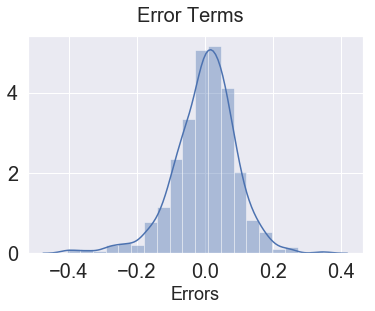

In [63]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

## Step 6:  Checking the various assumptions of Linear Regression

### 1. Linear Relationship between the features and target:

According to this assumption there is linear relationship between the features and target.Linear regression captures only linear relationship.This can be validated by plotting a scatter plot between the features and the target.

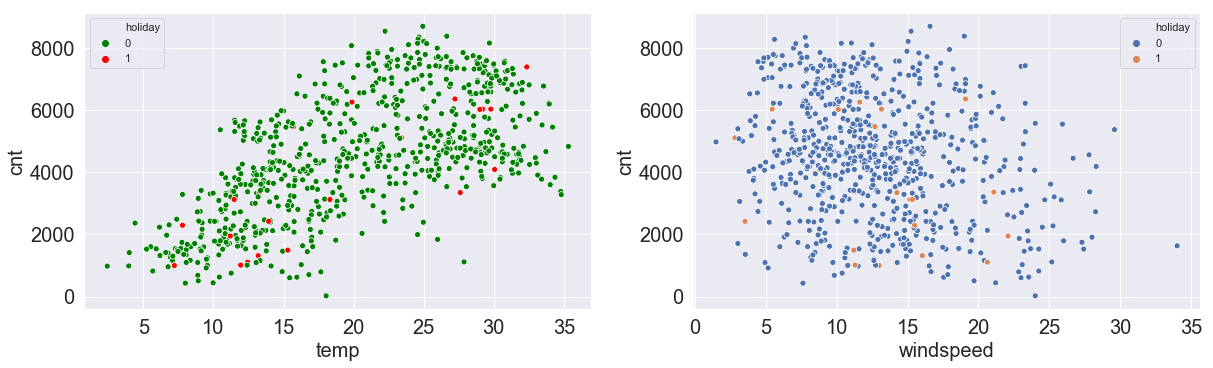

In [64]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.scatterplot(x = 'temp', y = 'cnt', hue='holiday' ,data = bike, palette=['green','red'])
plt.subplot(2,2,2)
sns.scatterplot(x = 'windspeed', y = 'cnt',hue='holiday', data = bike)


The first scatter plot of the feature Temp vs Cnt tells us that as temp increases upto a point there is increases count of total rental bikes linearly and the second scatter plot which is the feature windspeed vs Cnt also shows a partial linear relationship between them,although not completely linear.

### 2. Little or no Multicollinearity between the features:

In [65]:
vif = pd.DataFrame()
X = X_train_new8
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,16.53
8,temp,1.47
3,August,1.44
1,summer,1.37
2,winter,1.27
4,September,1.20
9,windspeed,1.09
5,Mist,1.05
6,Light_Snow,1.05
7,yr,1.02


As we can see , the various features in our model has VIF ~ 5 . That ensures , we dont have highly correlated predictors in our model

### 3. Normal distribution of error terms:


Normality Q-Q Plot:
As the name suggests, this plot is used to determine the normal distribution of errors. It uses standardized values of residuals. Ideally, this plot should show a straight line. 

Text(0.5,0.98,' Q-Q Plot of error terms')

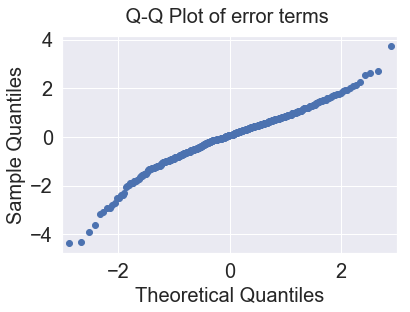

In [66]:
res= (y_train - y_train_cnt)
fig= sm.qqplot(res,fit=True)
fig.suptitle(' Q-Q Plot of error terms', fontsize = 20)   

As we can see our model has almost normal distribution of error.

Text(0.5,0,'Errors')

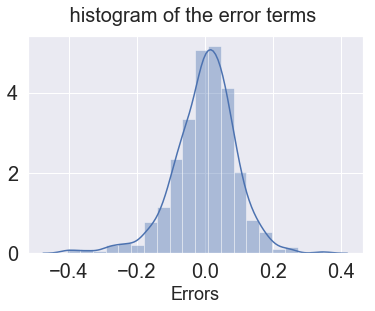

In [67]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle(' histogram of the error terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

### 5.Little or No autocorrelation in the residuals:

The error terms must be uncorrelated i.e. error at ∈t must not indicate the at error at ∈t+1. Presence of correlation in error terms is known as Autocorrelation. It drastically affects the regression coefficients and standard error values since they are based on the assumption of uncorrelated error terms

In [68]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_new8 = sm.add_constant(X_train_new8)

 # Running the linear model
lm = sm.OLS(y_train,X_train_new8).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     270.8
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          6.57e-186
Time:                        15:16:42   Log-Likelihood:                 490.01
No. Observations:                 510   AIC:                            -960.0
Df Residuals:                     500   BIC:                            -917.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1264      0.017      7.511      0.0

Our models's Durbin-Watson:2.00

* The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation

#### 6. Homoscedasticity (constant variance): 
The variance of the errors is constant with respect to the predicting variables or the response. Generally, non-constant variance arises in presence of outliers or extreme leverage values.
Fitted vs. residuals plot
When we plot the fitted target values  vs. the residuals, we clearly observe that the variance of the residuals increases with target variable magnitude. 


Text(0,0.5,'Residual')

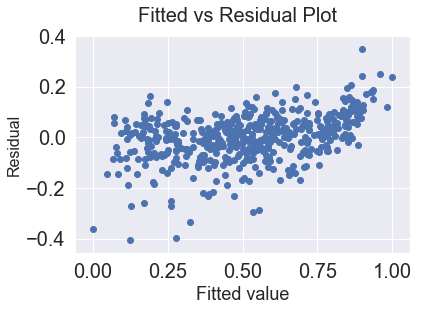

In [69]:
# Plotting Fitted vs Residual Plot to understand Homoscedasticity

fig = plt.figure()
plt.scatter(y_train,y_train - y_train_cnt )
fig.suptitle('Fitted vs Residual Plot', fontsize = 20)              
plt.xlabel('Fitted value', fontsize = 18)                          
plt.ylabel('Residual', fontsize = 16)   

As , you can see it has more of a constant variation and not a funnel shape showing  variance of the residuals increases or decreases with target variable .

#### Conclusion:
We have gone through the most important assumptions which must be kept in mind before fitting a Linear Regression Model to a given set of data.These assumptions are just a formal check to ensure that the linear model we build gives us the best possible results for a given data set and these assumptions if not satisfied does not stop us from building a Linear regression model.

## Step 7: Making Predictions Using the Final Model

Applying the scaling on the test sets

In [70]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.describe()

,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,...,weathersit_2,weathersit_3,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.264840,0.246575,0.232877,0.100457,0.054795,0.091324,0.086758,0.095890,0.105023,0.059361,...,0.319635,0.027397,0.479452,0.036530,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592
std,0.442259,0.432005,0.423633,0.301297,0.228100,0.288730,0.282125,0.295115,0.307285,0.236840,...,0.467403,0.163612,0.500722,0.188034,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300


#### Dividing into X_test and y_test

In [71]:
y_test = df_test.pop('cnt')
X_test = df_test
X_test.rename(columns = {'season_2':'summer', 'season_3':'fall', 
                              'season_4':'winter','mnth_8':'August','mnth_9':'September','mnth_10':'October',
                            'weekday_6':'Saturday','weathersit_2':'Mist','weathersit_3':'Light_Snow'
                             }, inplace = True) 

In [72]:
# Now let's use our model to make predictions.

X_train_new8=X_train_new8.drop(['const'],axis = 1)

X_test_new = X_test[X_train_new8.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

 # Running the linear model
lm = sm.OLS(y_test,X_test_new).fit()  

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     94.37
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.22e-68
Time:                        15:16:42   Log-Likelihood:                 200.53
No. Observations:                 219   AIC:                            -381.1
Df Residuals:                     209   BIC:                            -347.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0689      0.028      2.464      0.0

In [73]:
# Making predictions
y_pred = lm.predict(X_test_new)

In [74]:
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.009379562579599703
r_square_value : 0.8025180969671795


## Step 8: Model Evaluation

#### Let's now plot the graph for actual versus predicted values.

Text(0,0.5,'y_pred')

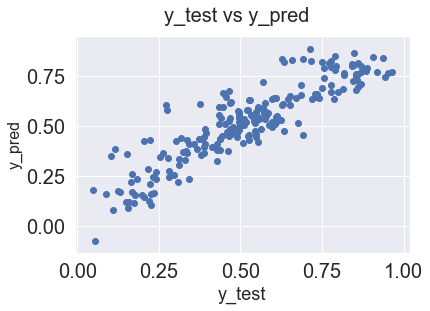

In [75]:
# Plotting y_test and y_pred 
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

**We can see that the equation of our best fitted line is:**

cnt = 0.1264 + 0.5572xtemp -0.2786xLight_Snow +0.2328xyr -0.1516xwindspeed +0.1374xwinter + 0.1133xSeptember + 0.1016xsummer  -0.0809xMist +0.0557xAugust

  #### Obseravtion about top 4 contribution features for bike demand
  
  
  • Temp    (β =0.557) min=2.424346 and max=35.328347 
  So as the temp increases count in rental bike also increases . As temp around 20-30 is considered favourable for customers for riding bike                                            
  
  • Light_snow (β =-0.232) 
  This  feature is better described as – Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds.It belongs to one of the weather category . It seems  this condition is not favourable to the customers. And thus this feature tends to decrease the count of rental bike.
  
  
  • Yr (β =0.236)
  This feature denotes 2019 year ( after first_drop during dummy variable creation.  In this year ie 2019 , there was a drastic increase in count of rental bike. It might be because of gradual popularity gain over years , health consciousness, environment or pollution related consciousness , increasing traffic where 2 wheeler is  a better option than 4 wheeler.
  
  
  • Windspped (β =-0.151)
  As windspeed can cause trouble to our customers while riding. So due to the uncomfort caused by it , the count of rental bikes seems to decrease with increase in windspeed 
